# Credit Card Fraud with Outlier Detection

## Introduction

This project uses anonymized credit card transaction data and attempts to detect outliers in the data that are linked to fraudulent transactions. The full original dataset can be found on [Kaggle](https://www.kaggle.com/datasets/whenamancodes/fraud-detection) and consists of 284,807 examples of 28 features collected over the course of two days in 2013. The features in this dataset have been anonymized and are products of a PCA transformation. No background information is available for the features or what they mean, and are named simply V1 - V28. The target variable is a binary outcome of if the transaction was found to be fraudulent or not. 

A key issue with this dataset, and the problem of outlier detection in general, is the very small amount of positive examples - only 489 out over 280,000 - which makes it very difficult to build a model that can accurately detect them. In real life it is imperative to detect as many fraudulent transactions as possible, but if there are too many false positives customers will have a negative experieence and they could lose trust in the fraud detection system. I was actually inspired to use this dataset because of how often my bank freezes my credit card even when making fairly routine purchases. Their fraud detection algorithm produces far too many false positives, which is not only annoying for the user but also undermines the effectiveness of the system and over time encourages users to ignore it's warnings. 

The ideal model for this problem will predict most fraudulent transactions and have relatively few false positives, though in this use case and because of the imbalanced data set we have some tolerance for false positives.


#### Problem Statement:
Using the provided feature data, create an algorithm that predicts the fraudulent transactions. Appropriate metrics are Area Under the Curve for both the Reciever Operating Characteristic (AUROC) and Precision-Recall Curves (AUPRC) as well as precision and recall. We will look at both unsupervised and supervised methods, and determine if an oversampling technique can overcome the problem of very rare positive examples. 

In [109]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# Set random seed
random_state = 12

In [120]:
cred = pd.read_csv('creditcard.csv')
cred.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.918649e-15,5.682686e-16,-8.761736e-15,2.811118e-15,-1.552103e-15,2.040130e-15,-1.698953e-15,-1.893285e-16,-3.147640e-15,...,1.473120e-16,8.042109e-16,5.282512e-16,4.456271e-15,1.426896e-15,1.701640e-15,-3.662252e-16,-1.217809e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [111]:
# The target label is 'Class'
# We can see that the dataset is incredibly imbalanced, with only 492 positive examples compared to 284,315 negative examples. 
cred.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [86]:
# Create X and y
X = cred.drop('Class', axis=1)
y = cred['Class']

Because there are 28 columns, we'll just visualize a few of them to see their distributions. The data has already been heavily processed so the distributions are aready on approximately the same scale. 

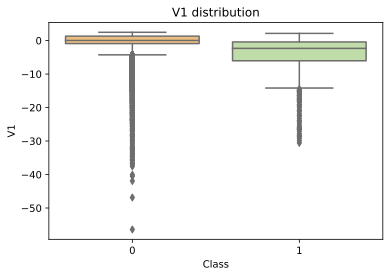

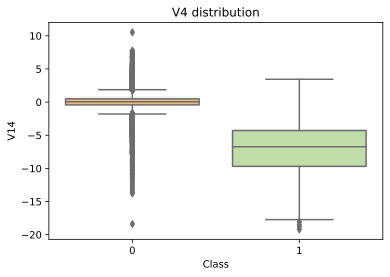

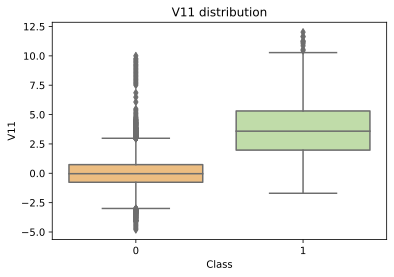

In [119]:
sns.boxplot(data=cred, x='Class', y='V1', palette='Spectral')
plt.title("V1 distribution")
plt.show()

sns.boxplot(data=cred, x='Class', y='V14', palette='Spectral')
plt.title("V4 distribution")
plt.show()

sns.boxplot(data=cred, x='Class', y='V11', palette='Spectral')
plt.title("V11 distribution")
plt.show()

### Analysis

The analysis will test three unsupervised methods and compare their results with two supervised methods, detailed below. Typically outlier detection algorithms are trained on [the entire dataset](https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_outlier_detection_bench.html) instead of a train/test split as the very low proportion of positive examples makes it difficult to create a representative test set.

Because the imbalanced nature of the dataset is such a big part of the problem statement, we will try two basic selective resampling approaches for dealing with imbalanced data: oversampling and undersampling. 

For metrics, there are a few different methods of measuring the effectiveness of outlier detection models. The most common are Area Under the ROC Curve and Precision-Recall Curve which [some researchers argue](https://arxiv.org/pdf/1811.02196.pdf) is more appropriate for outlier detection in imbalanced datasets than the ROC. Precsion, Recall and the confusion matrix are also displayed as part of the evaluation reporting.

#### Selective Resampling Approaches
* Oversampling
* Undersampling

#### Unsupervised Methods
* Isolation Forest 
* Local Outlier Factor
* Elliptical Envelope

#### Supervised Methods
* Logistic Regression
* Gradient Boosting

### Evaluation Metrics and Visualizations

In [136]:
from sklearn.metrics import confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay, ConfusionMatrixDisplay, precision_recall_curve
from sklearn.metrics import recall_score, precision_score, auc

def evaluate_model(y, y_pred, model_name, pos_label=1):
    """
    Function to display relevant plots and statistics for a model fit to this dataset. 
    Makes it easy to evaluate model performance at a glance.
    """
    print(f'Precision: {precision_score(y, y_pred)}, Recall: {recall_score(y, y_pred)}')
    display = RocCurveDisplay.from_predictions(
            y,
            y_pred,
            pos_label = pos_label ,
            name=model_name,
            linewidth=2)
    plt.plot([0, 1], [0, 1], linewidth=2, linestyle=":", color = 'green')
    plt.title(model_name + ' Score', fontsize=16)
    plt.show()
    
    PrecisionRecallDisplay.from_predictions(y, y_pred, name = model_name, pos_label = pos_label)
    plt.show()

    ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y, y_pred, labels=[0,1]), display_labels=[0,1]).plot()
    plt.show()
    
def get_pr_auc(y, y_pred):
    precision, recall, thresholds = precision_recall_curve(y, y_pred)
    # Use AUC function to calculate the area under the curve of precision recall curve
    auc_precision_recall = auc(recall, precision)
    return auc_precision_recall

### Over / Under Sampling of Imbalanced Classes

We'll try two different, if rather basic, selective resampling approaches to dealing with the problem of very rare positive examples: 

[Random Oversampling](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.RandomOverSampler.html#imblearn.over_sampling.RandomOverSampler) - This method randomly samples positive examples with replacement from the dataset and adds them back into the training data. 

[Random Undersampling](https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html) - This method relies on down-sampling negative examples so that the majority class does not dominate the dataset as much. Has the added benefit of reducing the size of the dataset and thus reducing training time. 

There are also synthetic oversampling techniques available like SMOTE and ADASYN that create new synthetic positive examples based on the characteristics of the real positive examples. But to keep the scope of this project reasonable we'll stick to just the basic resampling methods described above. 

To accomplish the over/under sampling we'll use a helpful library called [imblearn](https://imbalanced-learn.org/stable/over_sampling.html), which offers a number of tools for working with imbalanced datasets. 

The parameter that controls how much the dataset is over/undersampled is called 'sampling_strategy.' In this example with the Isolation Forests algorithm, we can optimize the sampling_strategy parameter. For both methods a sampling_strategy value of 0.01 proved optimal using the AUPRC metric. A value of 1 in the undersampling approach will not change the dataset at all, while for the oversampling approach a value of 1 will resample the positive examples until they equal the number of negative examples. Both methods work to balance the examples in the dataset.

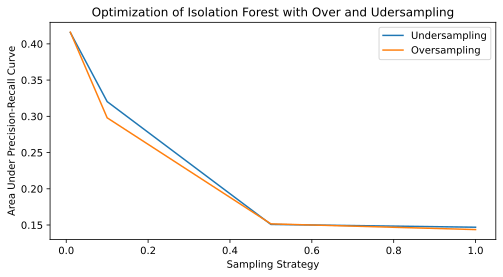

In [94]:
auc_under = [0.41565684130083663,0.32028534048667096,0.150827147518149,0.14696355596906635]
auc_over = [0.4160858602812263, 0.29792570685280323, 0.15159482925437348, 0.14371437165750717]

plt.figure(figsize=(8, 4))
plt.plot([0.01, 0.1, 0.5, 1], auc_under)
plt.plot([0.01, 0.1, 0.5, 1], auc_over)
plt.title('Optimization of Isolation Forest with Over and Udersampling')
plt.ylabel('Area Under Precision-Recall Curve')
plt.xlabel('Sampling Strategy')
plt.legend(['Undersampling','Oversampling'])
plt.show()

In [88]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state = random_state, sampling_strategy = 0.01)
X_undersampled, y_undersampled = rus.fit_resample(X, y)

print(f'Undersampled X dataset Contains {len(y_undersampled[y_undersampled==1])} positive and {len(y_undersampled[y_undersampled==0])} negative examples')

Undersampled X dataset Contains 492 positive and 49200 negative examples


In [89]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state = random_state, sampling_strategy = 0.01)
X_oversampled, y_oversampled = ros.fit_resample(X, y)

print(f'Oversampled X dataset Contains {len(y_oversampled[y_oversampled==1])} positive and {len(y_oversampled[y_oversampled==0])} negative examples')

Oversampled X dataset Contains 2843 positive and 284315 negative examples


## Unsupervised Methods


### Isolation Forest

[Isolation Forest Method](https://scikit-learn.org/stable/modules/outlier_detection.html) uses a random forest esemble to recursively partition the data to isolate outliers. The oversampled dataset gave better results so I'm using that dataset to train this model. 

Precision: 0.04495960660344222, Recall: 0.7804878048780488


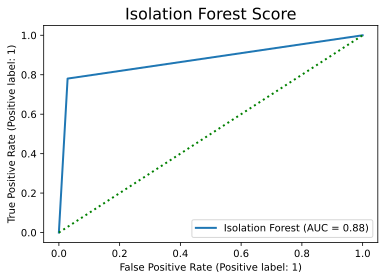

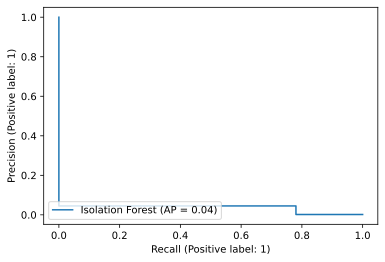

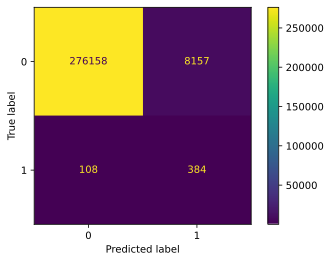

0.41291330782215496

In [75]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(random_state=random_state, n_estimators = 200)
iso.fit(X_oversampled)

y_pred = iso.predict(X) 

# Format Class Labels
y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1

evaluate_model(y, y_pred, model_name='Isolation Forest')
get_pr_auc(y, y_pred)

### Local Outlier Factor

[Local Outlier Factor](https://scikit-learn.org/stable/auto_examples/neighbors/plot_lof_outlier_detection.html?highlight=local+outlier) uses k-nearest neighbors to estimate the local density for individual sample clusters. Variations in density of sample clusters can be used to detect outliers that are subsatntially different than their neighbors. 

Over and Undersampling of the data tended to reduce performance for this method. I obtained better results through tuning the n_neighbors parameter, which determines how many neighbors are considered when measuring local density. The plot below shows the results of varyng the n_neighbors parameter from 5 to 50. Generally a lower number of neighbors produced higher recall and area under the precision-recall curve. 

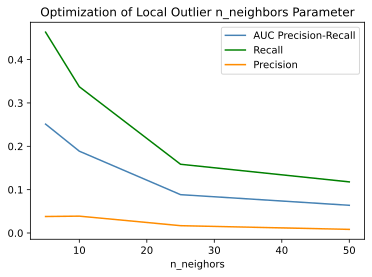

In [77]:
n_neighbors = [5, 10, 25, 50]
auc_pr = [0.25118663536650965, 0.18870034333706506, 0.08842206695379813, 0.06386033201838183]
rec = [0.4634146341463415, 0.33739837398373984, 0.15853658536585366, 0.11788617886178862]
prec = [0.03803169307756464, 0.03885767790262172, 0.016853932584269662, 0.008310646224387448]

plt.plot(n_neighbors, auc_pr, color='steelblue')
plt.plot(n_neighbors, rec, color='green')
plt.plot(n_neighbors, prec, color='darkorange')
plt.title('Optimization of Local Outlier n_neighbors Parameter')
plt.legend(['AUC Precision-Recall', 'Recall', 'Precision'])
plt.xlabel('n_neighors')
plt.show()

Precision: 0.03803169307756464, Recall: 0.4634146341463415


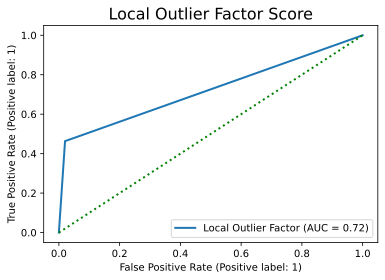

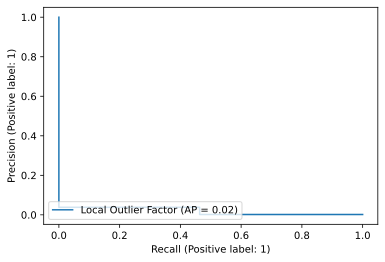

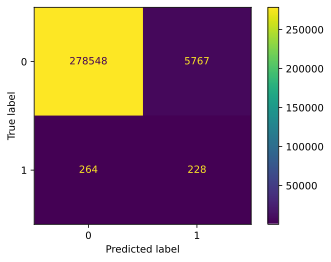

0.25118663536650965

In [87]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(n_neighbors=5, contamination="auto")
y_pred = lof.fit_predict(X)

# Format Class Labels
y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1

evaluate_model(y, y_pred, model_name = 'Local Outlier Factor')
get_pr_auc(y, y_pred)

### Elliptic Envelope

An [Gaussian outler detection](https://scikit-learn.org/stable/modules/generated/sklearn.covariance.EllipticEnvelope.html#sklearn.covariance.EllipticEnvelope) method that dynamically fits normal (Gaussian) decision boundaries to detect outliers in datasets. The basic over/undersampling techniques had little effect on the final results and have been omitted from this example. 


Precision: 0.015988482230810033, Recall: 0.8577235772357723


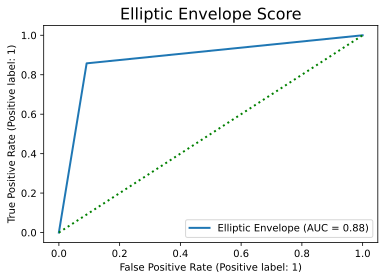

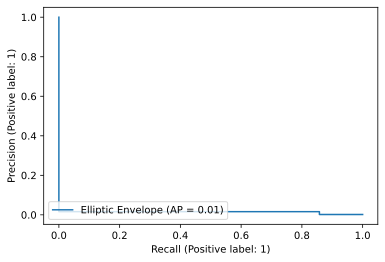

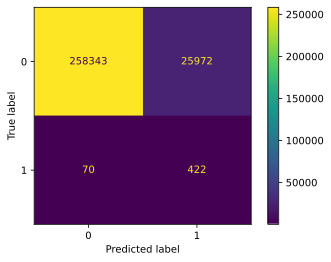

0.43697891997124183

In [90]:
from sklearn.covariance import EllipticEnvelope

eli = EllipticEnvelope(support_fraction = 0.95)
eli.fit(X_undersampled.drop('Time', axis=1)) 
y_pred = eli.predict(X.drop('Time', axis=1))     

# Format Class Labels
y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1

evaluate_model(y, y_pred, model_name='Elliptic Envelope')
get_pr_auc(y, y_pred)

### Comparison with Supervised Methods

For a comparison with supervised methods I tested two Supervised Classification methods: Logistic Regression and Random Forest Classifier. Because of the risk of overfitting I created a train and test set to help inform evaluation on these methods. 

#### Logistic Regression

Precision: 0.8532110091743119, Recall: 0.58125


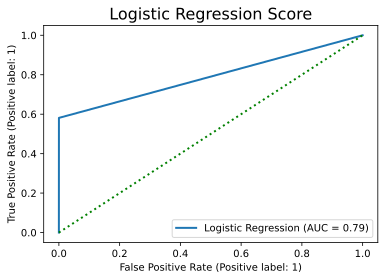

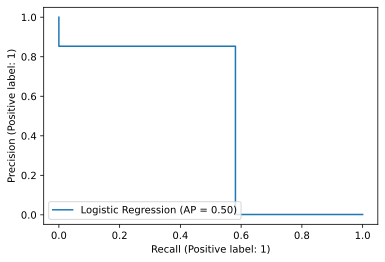

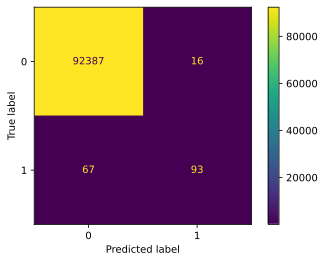

0.7175924202554035

In [81]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.325, random_state = random_state)

lr = LogisticRegression(random_state = random_state, max_iter = 800).fit(X_train, y_train)
y_pred = lr.predict(X_test)

evaluate_model(y_test, y_pred, model_name='Logistic Regression')
get_pr_auc(y_test, y_pred)

### Random Forest

After some tuning, I found the optimum number of estimators to be about 100. This creates a well fit model while also resulting in balanced train and test scores. 

Precision: 0.9461538461538461, Recall: 0.76875


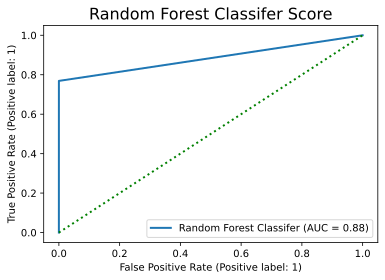

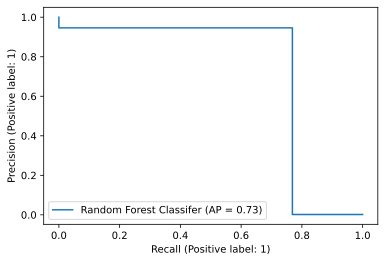

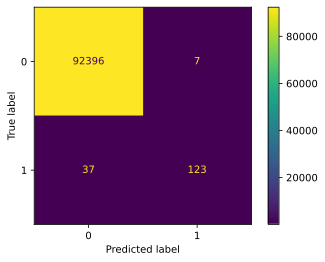

0.857651786953418
0.9548875726766133


In [101]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state = random_state, n_estimators = 100)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

evaluate_model(y_test, y_pred, model_name = 'Random Forest Classifer')
print(get_pr_auc(y_test, y_pred))

y_pred = rf.predict(X.drop('Time', axis=1))
print(get_pr_auc(y, y_pred))

### Results and Comparison

Much of the literature on Outlier detection focuses on the Area Under the ROC Curve (AUROC) metric. However, when the classes are so imbalanced a more helpful metric is [Area under the Precision Recall curve](https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html). This metric is helpful for understanding if we've correctly classified the rre positive examples, while the area under the ROC is easily inflated by correctly predicting the majority class of negative examples, which is not very interesting in this case. You can see in the graph below that AUROC is generally really high for most of the models but the AUPRC varies much more.

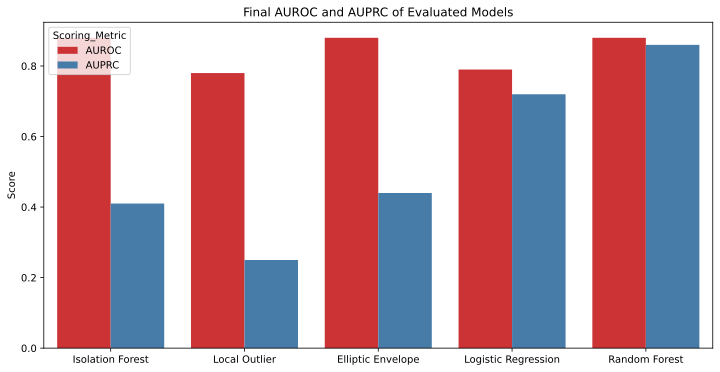

In [138]:
# AUPRC Scores
model_labels = ['Isolation Forest', 'Local Outlier', 'Elliptic Envelope', 'Logistic Regression', 'Random Forest']
score_labels = ['AUROC', 'AUROC', 'AUROC', 'AUROC', 'AUROC', 'AUPRC', 'AUPRC', 'AUPRC', 'AUPRC', 'AUPRC']

AUROC = [0.88, 0.78, 0.88, 0.79, 0.88]
AUPRC = [0.41, 0.25, 0.44, 0.72, 0.86]

scores = pd.DataFrame({'Model':model_labels + model_labels, 'Scoring_Metric': score_labels, 'Score': AUROC + AUPRC })

plt.figure(figsize=(12,6))
plt.title('Final AUROC and AUPRC of Evaluated Models')
sns.barplot(x = 'Model', y = 'Score',data = scores, hue='Scoring_Metric',  palette='Set1')
plt.xlabel('')
plt.show()

Another way to look at binary classifier performance like this is to examine the Precision and Recall of each model. 

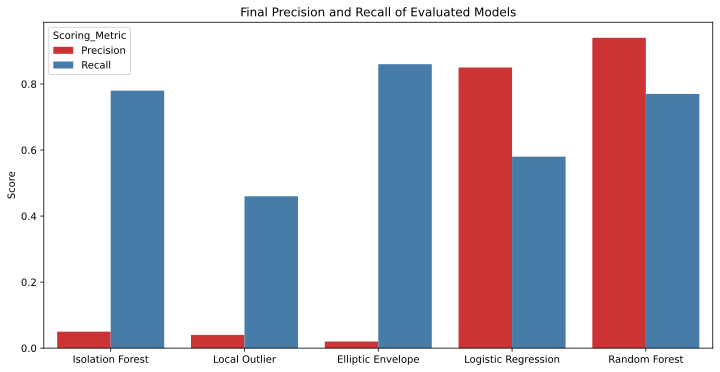

In [137]:
model_labels = ['Isolation Forest', 'Local Outlier', 'Elliptic Envelope', 'Logistic Regression', 'Random Forest']
score_labels = ['Precision', 'Precision', 'Precision', 'Precision', 'Precision',
                'Recall', 'Recall', 'Recall', 'Recall', 'Recall']

Precision = [0.05, 0.04, 0.02,0.85,0.94]
Recall = [0.78, 0.46, 0.86, 0.58, 0.77]

scores = pd.DataFrame({'Model':model_labels + model_labels, 'Scoring_Metric': score_labels, 'Score': Precision + Recall })

plt.figure(figsize=(12,6))
plt.title('Final Precision and Recall of Evaluated Models')
sns.barplot(x = 'Model', y = 'Score',data = scores, hue='Scoring_Metric', palette='Set1')
plt.xlabel('')
plt.show()

### Conclusions

The unsupervised methods I developed for this project performed fairly poorly in many respects on the dataset compared to the supervised methods, particularly in classifying the negative examples correctly. However, the evaluation needs to consider the use case where properly detecting fraudulent transactions is likely more important than correctly classifying legitimate transactions - to a point. Considering each of the four different metrics examined in the analysis:

* AUROC: This metric was fairly high for all models, despite the widely varying results, which really reinforced for me the notion that this metric is not really appropriate for the problem. The imblanaced nature of the dataset made it easy for a model to score really high on this metric while msising a large number of the positive examples. So this did not factor into the final evaluation 

* AUPRC: This metric seems a little more useful than AUROC. Some of the literature I looked at for this project suggested this as a better alternative to AUROC for imbalanced datasets, and I would say it's appropriate in this case. 

* Recall: Two of three unsupervised methods performed better than both supervised methods on this metric. There is an argument that this is the most important metric, because ultimately we want to detect as much fraud as possible. However, each model with high recall did also predict thousands of false positives. 

* Precision: All of the unsupervised methods performed very poorly in this metric, while the supervised methods performed very well. 

For the two selective sampling methods, Undersampling generally had slightly better results fo than Oversampling but neither technique did much to improve performance. If we really wanted to dig into this aspect of the problem there are a number of more sophisticated resampling techniques available that could give some better results. 

From the real world perspective of how an outlier detection model would be used, I think one of the recall based metrics is most appropriate. If it were my decision I would probably go with either the Isolation Forest or Random Forest models. The real test would be how these models perform on new data and how they can be adapted over time. Credit card companies have much more sophisticated fraud detection algorithms that will respond to new techniques developed by scammers and theives over time. 

### References

[Credit Card Fraud Detection in e-commerce: An Outlier Detection Approach](https://arxiv.org/pdf/1811.02196.pdf). Utkarsh Porwal and Smuthi Mukund. Preprint Publication. March 2019.

[Learned lessons in credit card fraud detection from a practitioner perspective](https://www.sciencedirect.com/science/article/abs/pii/S095741741400089X). Dal Pozzolo, Andrea; Caelen, Olivier; Le Borgne, Yann-Ael; Waterschoot, Serge; Bontempi, Gianluca. Expert systems with applications. August 2014

Other software documentation cited above near where it was referenced.